In [1]:
import deimos
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold
import random as rd
import matplotlib
matplotlib.rcParams['figure.dpi'] = 200
import sys
sys.path.append("../src/")
sys.path.append("D:/metabolome_inference/metabolome_inference/src/")
from PeakDetective import rawData,PeakDetective,Classifier,Smoother,normalizeMatrix,safeNormalize
import detection_helper
import scipy.stats as stats
import seaborn as sb
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import confusion_matrix
import sklearn.metrics as met
import NeatMS as ntms
from copy import deepcopy

In [2]:
datadir = "../data/mzMLs/covid_plasma/"
resolution = 60

In [3]:
ms1ppm = 30
peakWidth = (10,83)
s2n = 5
noise = 500
det = detection_helper.PeakList()
#det.runXCMS(datadir, "xcms_peak_list.csv", "negative", ms1ppm, peakWidth,s2n=s2n,noise=noise)
det.readXCMSPeakList(datadir+"xcms_peak_list.csv")
det.to_skyline(datadir+"xcms_peak_list_transition_list.csv","Negative",moleculeListName = "XCMS peaks")
peakList = pd.DataFrame(det.peakList)
peakList["rt"] = .5 * peakList["rt_start"] + .5 * peakList["rt_end"]
peakList = peakList[["mz","rt"]]
peakList

,mz,rt
1,52.995260,5.082550
2,54.977009,5.083667
3,55.019199,6.030133
4,57.034543,5.399525
5,57.034540,1.583142
...,...,...
3928,1612.974731,6.589500
3929,1612.974770,2.198033
3930,1613.978781,15.015317
3931,1613.978738,2.198033


In [4]:
neatMSPeakList = pd.read_csv(datadir + "xcms_peak_list.csv")
neatMSPeakList["feature_id"] = neatMSPeakList.index.values
neatMSPeakList["feature_id2"] = neatMSPeakList.index.values
neatMSPeakList = neatMSPeakList.melt(id_vars = ["mz","rt","rtmin","rtmax","feature_id"],
                    value_vars = [x for x in neatMSPeakList.columns.values if ".mzML" in x],
                   var_name="sample", value_name="into")
neatMSPeakList["mzmin"] = neatMSPeakList["mz"].values - (ms1ppm * neatMSPeakList["mz"].values) / 1e6
neatMSPeakList["mzmax"] = neatMSPeakList["mz"].values + (ms1ppm * neatMSPeakList["mz"].values) / 1e6
neatMSPeakList["intb"] = neatMSPeakList["into"].values
neatMSPeakList["maxo"] = neatMSPeakList["into"].values
neatMSPeakList["sn"] = [10 for _ in range(len(neatMSPeakList))]
neatMSPeakList["sample_name"] = neatMSPeakList["sample"].values
neatMSPeakList["rtmin"] = neatMSPeakList["rtmin"].values - .2 * 60
neatMSPeakList["rtmax"] = neatMSPeakList["rtmin"].values + .2 * 60

neatMSPeakList.to_csv(datadir + "neatms_peak_list.csv",index=False)
neatMSPeakList


,mz,rt,rtmin,rtmax,feature_id,sample,into,mzmin,mzmax,intb,maxo,sn,sample_name
0,52.995260,304.441,292.307,304.307,0,B1_NIST1950_1_6540.mzML,7850.116539,52.993670,52.996850,7850.116539,7850.116539,10,B1_NIST1950_1_6540.mzML
1,54.977009,305.304,292.441,304.441,1,B1_NIST1950_1_6540.mzML,154363.588813,54.975359,54.978658,154363.588813,154363.588813,10,B1_NIST1950_1_6540.mzML
2,55.019199,361.808,349.162,361.162,2,B1_NIST1950_1_6540.mzML,10993.804185,55.017548,55.020849,10993.804185,10993.804185,10,B1_NIST1950_1_6540.mzML
3,57.034543,324.256,311.553,323.553,3,B1_NIST1950_1_6540.mzML,13401.526777,57.032832,57.036254,13401.526777,13401.526777,10,B1_NIST1950_1_6540.mzML
4,57.034540,93.979,81.844,93.844,4,B1_NIST1950_1_6540.mzML,36009.587587,57.032829,57.036251,36009.587587,36009.587587,10,B1_NIST1950_1_6540.mzML
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11791,1612.974731,395.370,383.370,395.370,3927,B1_NIST1950_3_6540.mzML,39259.612620,1612.926342,1613.023120,39259.612620,39259.612620,10,B1_NIST1950_3_6540.mzML
11792,1612.974770,131.882,119.882,131.882,3928,B1_NIST1950_3_6540.mzML,8471.125168,1612.926380,1613.023159,8471.125168,8471.125168,10,B1_NIST1950_3_6540.mzML
11793,1613.978781,900.919,888.919,900.919,3929,B1_NIST1950_3_6540.mzML,9734.476091,1613.930361,1614.027200,9734.476091,9734.476091,10,B1_NIST1950_3_6540.mzML
11794,1613.978738,131.882,119.882,131.882,3930,B1_NIST1950_3_6540.mzML,3014.541264,1613.930319,1614.027157,3014.541264,3014.541264,10,B1_NIST1950_3_6540.mzML


In [5]:
feature_table_path = datadir+"neatms_peak_list.csv"
input_data = 'xcms'
experiment = ntms.Experiment(datadir+"tmp", feature_table_path, input_data)

In [5]:
pkl_file = "../data/neatms/NeatMS_covid_data.pkl"
import pickle
with open(pkl_file, 'rb') as f:
    experiment = pickle.load(f)

In [6]:
nn_handler = ntms.NN_handler(experiment,min_scan_num=0)

In [7]:
model_path = "../data/neatms/neatms_default_model.h5"
nn_handler.create_model(model = model_path)
nn_handler.get_model_summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2, 120, 1)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 120, 32)        832       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 60, 32)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 60, 64)         18496     
                                                                 
 flatten_1 (Flatten)         (None, 7680)              0         
                                                                 
 dense_1 (Dense)             (None, 128)               983168    
                                                           

In [8]:
# Set the threshold to 0.22
threshold=0.22
# Run the prediction
nn_handler.predict_peaks(threshold)

80/80 [==============================] - 0s 6ms/step


In [9]:
# We create the dataframe using this function
NeatMS_output_df = experiment.export_to_dataframe()
# And display it
NeatMS_output_df

,feature ID,sample,m/z,retention time,height,area,label
0,1,B1_NIST1950_1_6540,54.977009,5.088400,154363.588813,154363.588813,Noise
1,1,B1_NIST1950_2_6540,54.977009,5.088400,119400.154739,119400.154739,Noise
2,1,B1_NIST1950_3_6540,54.977009,5.088400,121714.576122,121714.576122,Noise
3,2,B1_NIST1950_1_6540,55.019199,6.030133,10993.804185,10993.804185,Noise
4,2,B1_NIST1950_2_6540,55.019199,6.030133,10215.497486,10215.497486,Noise
...,...,...,...,...,...,...,...
7112,3929,B1_NIST1950_2_6540,1613.978781,15.015317,36947.591704,36947.591704,High_quality
7113,3929,B1_NIST1950_3_6540,1613.978781,15.015317,9734.476091,9734.476091,Noise
7114,3930,B1_NIST1950_1_6540,1613.978738,2.198033,3175.045955,3175.045955,Noise
7115,3930,B1_NIST1950_2_6540,1613.978738,2.198033,51332.266490,51332.266490,Noise


In [5]:
files = [x for x in os.listdir(datadir) if ".mzML" in x]
print(files)
raw_data = []
for file in files:
    temp = rawData()
    temp.readRawDataFile(datadir + file,ms1ppm)
    raw_data.append(temp)

['B1_NIST1950_1_6540.mzML', 'B1_NIST1950_2_6540.mzML', 'B1_NIST1950_3_6540.mzML']


In [6]:
integ = PeakDetective(numCores = 20,resolution=resolution)

In [7]:
Smoother(resolution).summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 60)]              0         
                                                                 
 reshape_3 (Reshape)         (None, 60, 1)             0         
                                                                 
 conv1d_6 (Conv1D)           (None, 58, 32)            128       
                                                                 
 conv1d_7 (Conv1D)           (None, 56, 16)            1552      
                                                                 
 conv1d_8 (Conv1D)           (None, 54, 8)             392       
                                                                 
 conv1d_9 (Conv1D)           (None, 52, 4)             100       
                                                                 
 flatten_3 (Flatten)         (None, 208)               0   

In [ ]:
if __name__ == "__main__":
    inds = list(peakList.index.values)
    inds = rd.sample(inds,500)
    tmp = peakList.loc[inds,:]
    print(tmp)
    peakList_labeled = integ.label_peaks(raw_data[0],tmp)

              mz         rt
404   115.013673   5.204767
1999  272.887903   9.033250
3851  981.994702  10.496183
3776  900.787340  10.144417
1235  199.059813   5.071783
...          ...        ...
1188  194.987968   8.002550
3327  540.507945   0.835058
3397  562.490804   0.826750
1643  242.944088  12.951667
2708  379.210740   0.810117

[500 rows x 2 columns]
forming matrix |█████---------------------------------------------| 10.0% 

In [ ]:
peakList_labeled.to_csv(datadir + files[0].replace(".mzML","_classified_peaks.csv"))

In [8]:
peakList_labeled = pd.read_csv(datadir + files[0].replace(".mzML","_classified_peaks.csv"),index_col=0)

In [9]:
peakList_labeled

,mz,rt,classification
3714,779.422724,0.934800,1.0
839,163.043705,0.918175,1.0
2305,307.263816,0.826750,1.0
628,138.873950,5.057608,1.0
573,133.050540,1.415567,1.0
...,...,...,...
3737,824.307493,0.910983,1.0
2441,333.166292,4.351075,1.0
18,59.013809,2.540158,0.0
1235,199.059813,5.071783,0.0


In [10]:
filt = NeatMS_output_df[NeatMS_output_df["sample"] == files[0].replace(".mzML","")]
filt

NameError: name 'NeatMS_output_df' is not defined

In [16]:
matchIDs = {}
for index,row in peakList_labeled.iterrows():
    for index2,row2 in filt.iterrows():
        if row2["m/z"] > row["mz"] + 0.001:
            break
        if np.abs(row["rt"] - row2["retention time"]) < 0.03:
            if np.abs(row["mz"] - row2["m/z"]) < 0.001:
                matchIDs[index] = index2
                break
print(len(matchIDs))        

200


In [17]:
order = list(matchIDs.keys())
filt = filt.loc[[matchIDs[x] for x in order],:]
classification = []
for index,row in filt.iterrows():
    if row["label"] == "High_quality":
        classification.append(1.0)
    else:
        classification.append(0.0)
filt["classification"] = classification
filt

,feature ID,sample,m/z,retention time,height,area,label,classification
6742,3713,B1_NIST1950_1_6540,779.422724,0.934583,7.848981e+03,7.848981e+03,Noise,0.0
1288,572,B1_NIST1950_1_6540,133.050540,1.416900,4.062648e+04,4.062648e+04,Noise,0.0
6737,3709,B1_NIST1950_1_6540,772.753233,13.072950,5.535700e+03,5.535700e+03,Noise,0.0
5283,2632,B1_NIST1950_1_6540,364.905639,13.086900,1.243285e+05,1.243285e+05,Noise,0.0
4020,1923,B1_NIST1950_1_6540,260.023851,6.071483,6.718868e+03,6.718868e+03,Noise,0.0
...,...,...,...,...,...,...,...,...
1544,700,B1_NIST1950_1_6540,147.065234,6.387333,8.479394e+03,8.479394e+03,Noise,0.0
167,64,B1_NIST1950_1_6540,60.993011,10.441400,3.090565e+05,3.090565e+05,Noise,0.0
3484,1707,B1_NIST1950_1_6540,248.973514,4.202583,1.320179e+07,1.320179e+07,Noise,0.0
3825,1844,B1_NIST1950_1_6540,255.233027,1.908442,3.435614e+05,3.435614e+05,Noise,0.0


In [18]:
true_neatms = peakList_labeled.loc[order,"classification"].values
pred_neatms = filt["classification"].values
print(len(true_neatms),confusion_matrix(true_neatms,pred_neatms))
met.accuracy_score(true_neatms,pred_neatms)

200 [[95  2]
 [93 10]]


0.525

In [44]:
annotation_tool = ntms.AnnotationTool(experiment)
annotation_tool.launch_annotation_tool()

In [19]:
annotation_table = experiment.feature_tables[0].annotation_table
print("Total number of annotated peaks:",len(annotation_table.labelled_peaks))
for annotation in annotation_table.annotations:
    print(annotation.label,len(annotation.peaks))

Total number of annotated peaks: 203
High_quality 51
Low_quality 33
Noise 119


In [20]:
experiment.name = '../data/neatms/NeatMS_covid_data'
experiment.save()

In [20]:
# Let's freeze the convolutional base
# We can do that by selecting layers using their names

layer_names = ['conv2d_1','conv2d_2','max_pooling2d_1']
for layer_name in layer_names:
    nn_handler.class_model.get_layer(layer_name).trainable = False

# Here is how to make sure that the right layers are still trainable
for layer in nn_handler.class_model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x000001D3F84758C8> True
<keras.layers.convolutional.conv2d.Conv2D object at 0x000001D3F8444BC8> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001D3F8440E48> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000001D3F8469488> False
<keras.layers.reshaping.flatten.Flatten object at 0x000001D3F8464048> True
<keras.layers.core.dense.Dense object at 0x000001D3F8464648> True
<keras.layers.regularization.dropout.Dropout object at 0x000001D3F84700C8> True
<keras.layers.core.dense.Dense object at 0x000001D3F8470988> True


In [21]:
from keras.optimizers import SGD, Adam 
lr = 0.00001
opt = Adam(lr=lr)
nn_handler.class_model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics=['accuracy','mae'])

c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [22]:
nn_handler.create_batches(validation_split=0.1, normalise_class=False)

In [24]:
nn_handler.train_model(20)

Epoch 1/20
4/4 [==============================] - 0s 36ms/step - loss: 1.4200 - accuracy: 0.5941 - mae: 0.3163 - val_loss: 1.5602 - val_accuracy: 0.5000 - val_mae: 0.3545
Epoch 2/20
4/4 [==============================] - 0s 23ms/step - loss: 1.3911 - accuracy: 0.5644 - mae: 0.3097 - val_loss: 1.5520 - val_accuracy: 0.5000 - val_mae: 0.3541
Epoch 3/20
4/4 [==============================] - 0s 20ms/step - loss: 1.3941 - accuracy: 0.5545 - mae: 0.3174 - val_loss: 1.5427 - val_accuracy: 0.5000 - val_mae: 0.3539
Epoch 4/20
4/4 [==============================] - 0s 20ms/step - loss: 1.2651 - accuracy: 0.5941 - mae: 0.3115 - val_loss: 1.5345 - val_accuracy: 0.5000 - val_mae: 0.3537
Epoch 5/20
4/4 [==============================] - 0s 20ms/step - loss: 1.3596 - accuracy: 0.5446 - mae: 0.3187 - val_loss: 1.5255 - val_accuracy: 0.5000 - val_mae: 0.3530
Epoch 6/20
4/4 [==============================] - 0s 21ms/step - loss: 1.1126 - accuracy: 0.5842 - mae: 0.2893 - val_loss: 1.5144 - val_accuracy:

In [25]:
nn_handler.class_model.save("../data/neatms/covid_model_tl.h5")

In [26]:
# Set the threshold to 0.22
threshold=0.22

# Run the prediction
nn_handler.predict_peaks(threshold)

80/80 [==============================] - 1s 6ms/step


In [27]:
# We create the dataframe using this function
NeatMS_output_df_tl = experiment.export_to_dataframe()
# And display it
NeatMS_output_df_tl

,feature ID,sample,m/z,retention time,height,area,label
0,1,B1_NIST1950_1_6540,54.977009,5.088400,154363.588813,154363.588813,High_quality
1,1,B1_NIST1950_2_6540,54.977009,5.088400,119400.154739,119400.154739,High_quality
2,1,B1_NIST1950_3_6540,54.977009,5.088400,121714.576122,121714.576122,High_quality
3,2,B1_NIST1950_1_6540,55.019199,6.030133,10993.804185,10993.804185,Noise
4,2,B1_NIST1950_2_6540,55.019199,6.030133,10215.497486,10215.497486,Noise
...,...,...,...,...,...,...,...
7112,3929,B1_NIST1950_2_6540,1613.978781,15.015317,36947.591704,36947.591704,High_quality
7113,3929,B1_NIST1950_3_6540,1613.978781,15.015317,9734.476091,9734.476091,Noise
7114,3930,B1_NIST1950_1_6540,1613.978738,2.198033,3175.045955,3175.045955,Noise
7115,3930,B1_NIST1950_2_6540,1613.978738,2.198033,51332.266490,51332.266490,High_quality


In [28]:
filt = NeatMS_output_df_tl[NeatMS_output_df_tl["sample"] == files[0].replace(".mzML","")]
filt = filt.loc[[matchIDs[x] for x in order],:]
classification = []
for index,row in filt.iterrows():
    if row["label"] == "High_quality":
        classification.append(1.0)
    else:
        classification.append(0.0)
filt["classification"] = classification
filt

,feature ID,sample,m/z,retention time,height,area,label,classification
6742,3713,B1_NIST1950_1_6540,779.422724,0.934583,7.848981e+03,7.848981e+03,Noise,0.0
1288,572,B1_NIST1950_1_6540,133.050540,1.416900,4.062648e+04,4.062648e+04,Noise,0.0
6737,3709,B1_NIST1950_1_6540,772.753233,13.072950,5.535700e+03,5.535700e+03,High_quality,1.0
5283,2632,B1_NIST1950_1_6540,364.905639,13.086900,1.243285e+05,1.243285e+05,High_quality,1.0
4020,1923,B1_NIST1950_1_6540,260.023851,6.071483,6.718868e+03,6.718868e+03,High_quality,1.0
...,...,...,...,...,...,...,...,...
1544,700,B1_NIST1950_1_6540,147.065234,6.387333,8.479394e+03,8.479394e+03,Low_quality,0.0
167,64,B1_NIST1950_1_6540,60.993011,10.441400,3.090565e+05,3.090565e+05,Noise,0.0
3484,1707,B1_NIST1950_1_6540,248.973514,4.202583,1.320179e+07,1.320179e+07,Noise,0.0
3825,1844,B1_NIST1950_1_6540,255.233027,1.908442,3.435614e+05,3.435614e+05,Noise,0.0


In [29]:
true_neatms_tl = peakList_labeled.loc[order,"classification"].values
pred_neatms_tl = filt["classification"].values
print(len(true_neatms_tl),confusion_matrix(true_neatms_tl,pred_neatms_tl))
met.accuracy_score(true_neatms_tl,pred_neatms_tl)

200 [[82 15]
 [31 72]]


0.77

In [11]:
peakList

,mz,rt
1,52.995260,5.082550
2,54.977009,5.083667
3,55.019199,6.030133
4,57.034543,5.399525
5,57.034540,1.583142
...,...,...
3928,1612.974731,6.589500
3929,1612.974770,2.198033
3930,1613.978781,15.015317
3931,1613.978738,2.198033


In [12]:
#format X
if __name__ == "__main__":
    ms1_peaks_curated,X_norm,X_orig,tics,scores,progress,peak_scores = integ.curatePeaks(raw_data,peakList,min_peaks=50000,shift=2.0,smooth_epochs=10,threshold=0.99)

9/9 [==============================] - 0s 3ms/step
done
training classifier...
Epoch 1/10
498/498 [==============================] - 3s 5ms/step - loss: 0.6826 - mean_absolute_error: 0.4827 - val_loss: 0.6696 - val_mean_absolute_error: 0.4739
Epoch 2/10
498/498 [==============================] - 2s 5ms/step - loss: 0.5202 - mean_absolute_error: 0.3202 - val_loss: 0.4819 - val_mean_absolute_error: 0.2790
Epoch 3/10
498/498 [==============================] - 2s 5ms/step - loss: 0.2899 - mean_absolute_error: 0.1288 - val_loss: 0.2769 - val_mean_absolute_error: 0.1204
Epoch 4/10
498/498 [==============================] - 2s 5ms/step - loss: 0.1644 - mean_absolute_error: 0.0614 - val_loss: 0.1739 - val_mean_absolute_error: 0.0702
Epoch 5/10
498/498 [==============================] - 2s 5ms/step - loss: 0.1094 - mean_absolute_error: 0.0398 - val_loss: 0.1165 - val_mean_absolute_error: 0.0467
Epoch 6/10
498/498 [==============================] - 2s 5ms/step - loss: 0.0831 - mean_absolute_erro

In [13]:
ms1_peaks_curated

{'../data/mzMLs/covid_plasma/B1_NIST1950_1_6540.mzML':                mz         rt
 2       54.977009   5.083667
 3       55.019199   6.030133
 4       57.034543   5.399525
 5       57.034540   1.583142
 6       56.995904  13.078800
 ...           ...        ...
 3911  1134.336721   7.701983
 3912  1144.635590  13.056317
 3914  1175.773152   0.919300
 3915  1176.777577   0.917967
 3932  1614.976147   2.198033
 
 [2992 rows x 2 columns],
 '../data/mzMLs/covid_plasma/B1_NIST1950_2_6540.mzML':                mz         rt
 2       54.977009   5.083667
 3       55.019199   6.030133
 4       57.034543   5.399525
 5       57.034540   1.583142
 6       56.995904  13.078800
 ...           ...        ...
 3923  1612.976393  14.998683
 3929  1612.974770   2.198033
 3930  1613.978781  15.015317
 3931  1613.978738   2.198033
 3932  1614.976147   2.198033
 
 [3001 rows x 2 columns],
 '../data/mzMLs/covid_plasma/B1_NIST1950_3_6540.mzML':                mz         rt
 2       54.977009   5.083667
 3

[11796, 512, 397, 349, 304]


Text(0, 0.5, 'log10(# of uncertain peaks)')

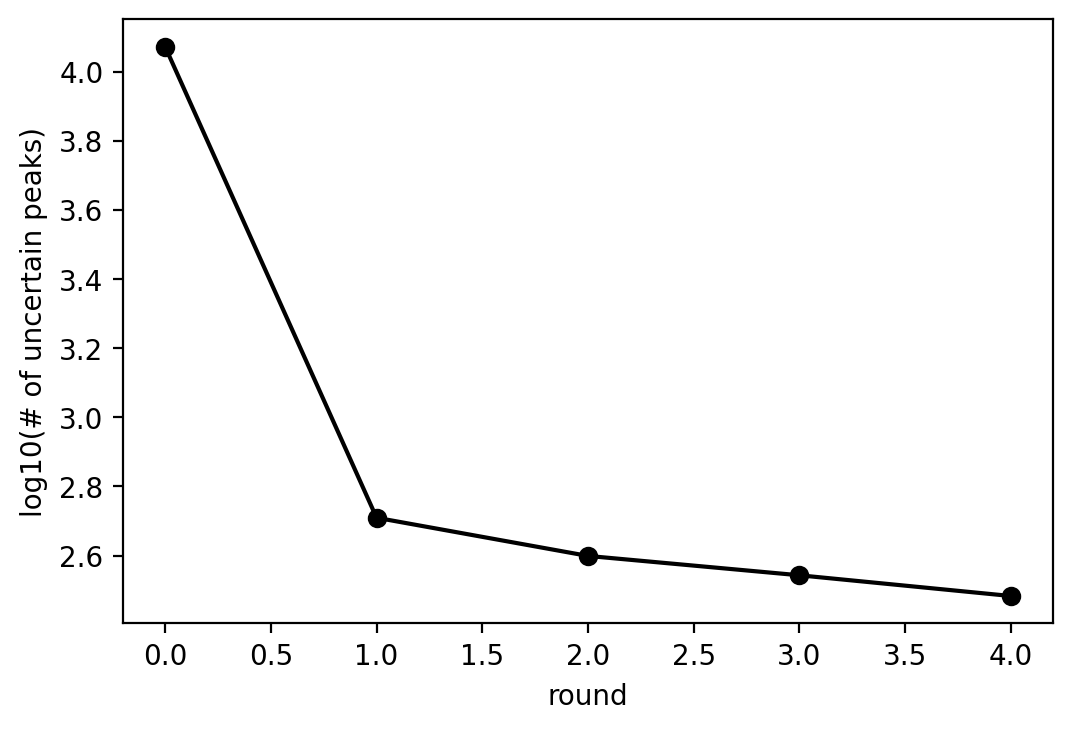

In [14]:
print(progress)
plt.plot(list(range(len(progress))),np.log10(progress),color="black")
plt.scatter(list(range(len(progress))),np.log10(progress),color="black")
plt.xlabel("round")
plt.ylabel("log10(# of uncertain peaks)")

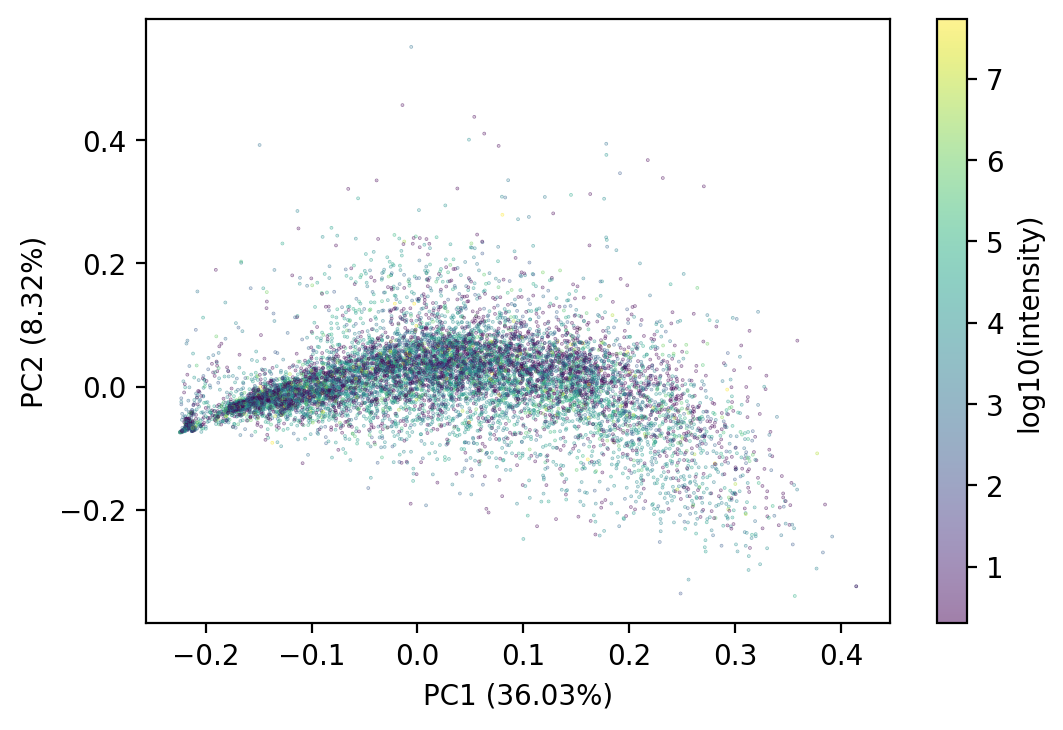

In [15]:
pca = PCA(2)
loads = pca.fit_transform(X_orig)
plt.scatter(loads[:,0],loads[:,1],c=tics,s=.1,alpha=.5)
plt.xlabel("PC1 (" + str(np.round(100*pca.explained_variance_ratio_[0],2)) + "%)")
plt.ylabel("PC2 (" + str(np.round(100*pca.explained_variance_ratio_[1],2)) + "%)")
plt.colorbar(label="log10(intensity)")

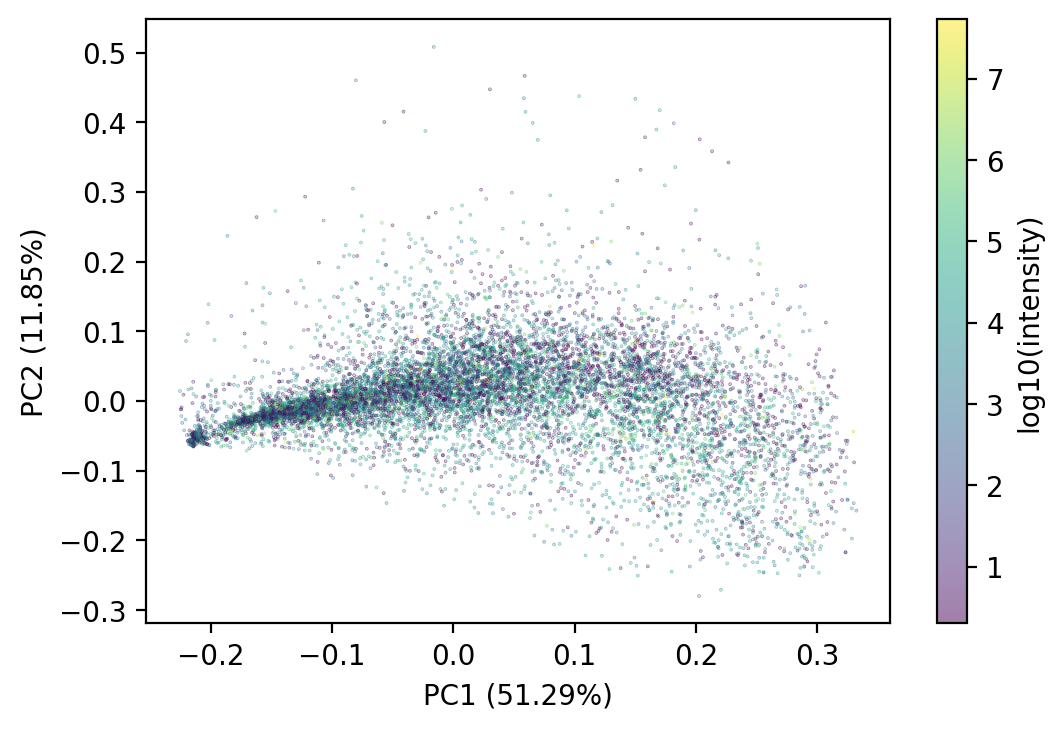

In [16]:
pca = PCA(2)
loads = pca.fit_transform(X_norm)
plt.scatter(loads[:,0],loads[:,1],c=tics,s=.1,alpha=.5)
plt.xlabel("PC1 (" + str(np.round(100*pca.explained_variance_ratio_[0],2)) + "%)")
plt.ylabel("PC2 (" + str(np.round(100*pca.explained_variance_ratio_[1],2)) + "%)")
plt.colorbar(label="log10(intensity)")

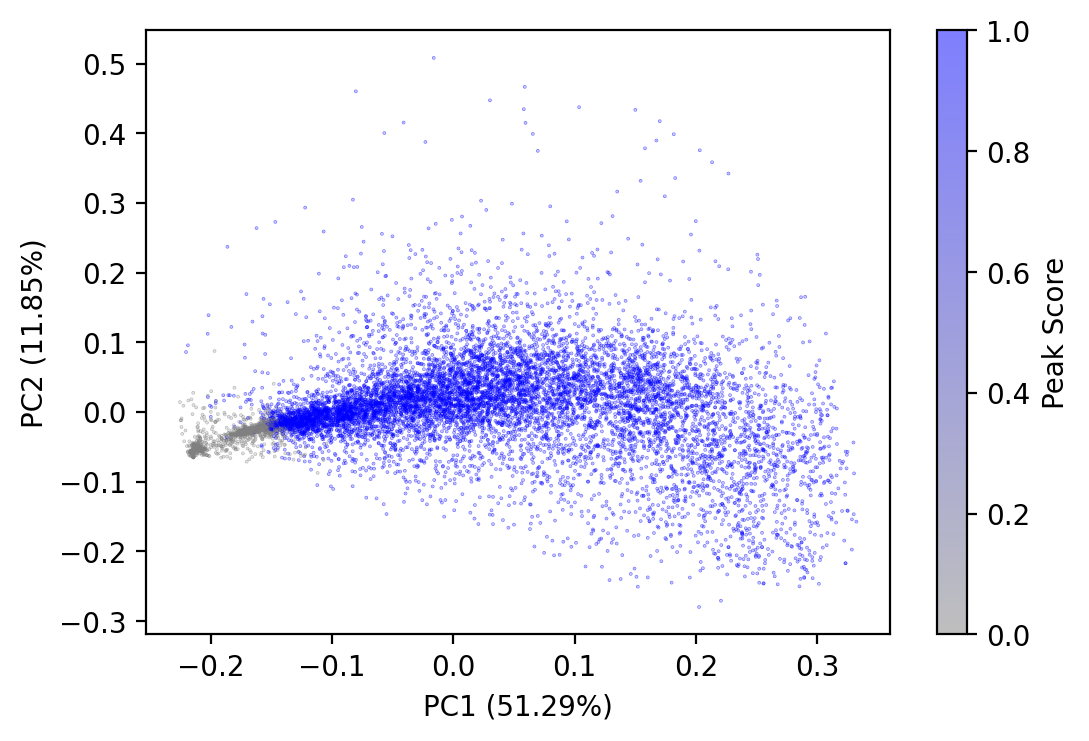

In [17]:
pca = PCA(2)
loads = pca.fit_transform(X_norm)
colormap = LinearSegmentedColormap.from_list("test",colors=["grey", "blue"],N=256)
plt.scatter(loads[:,0],loads[:,1],c=scores,s=.1,alpha=.5,cmap=colormap)
plt.xlabel("PC1 (" + str(np.round(100*pca.explained_variance_ratio_[0],2)) + "%)")
plt.ylabel("PC2 (" + str(np.round(100*pca.explained_variance_ratio_[1],2)) + "%)")
plt.colorbar(label="Peak Score")

Text(0, 0.5, '% of features')

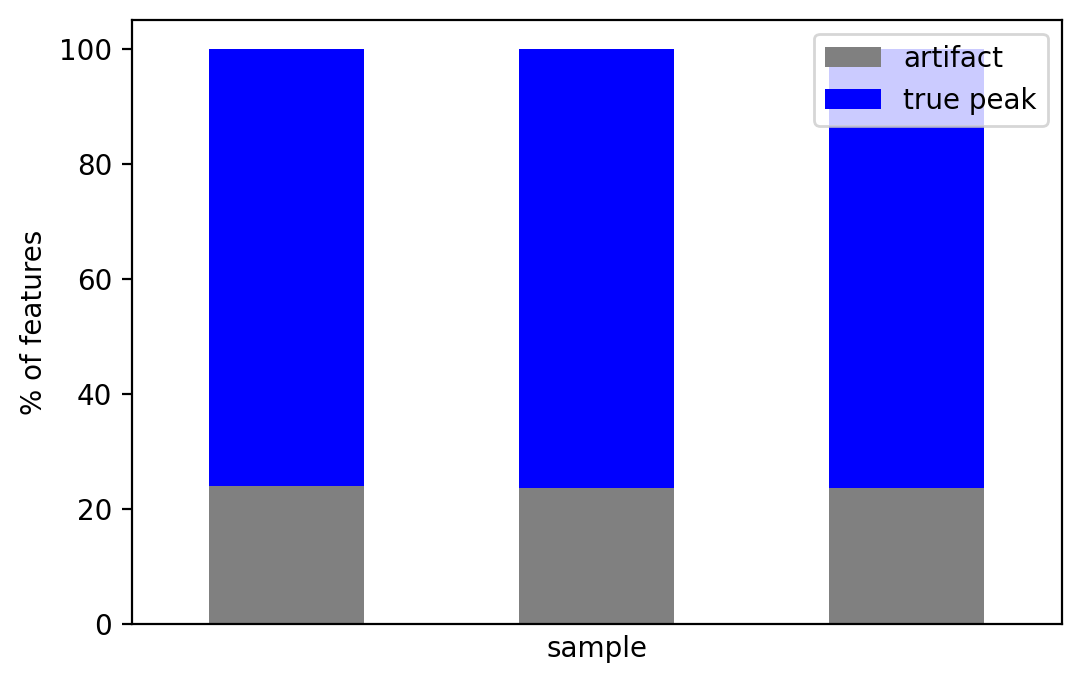

In [18]:
df = {}
for file in files:
    for index,row in peakList.iterrows():
        if index in ms1_peaks_curated[datadir + file].index.values:
            df[len(df)] = {"sample":file,"classification":"true peak"}
        else:
            df[len(df)] = {"sample":file,"classification":"artifact"}

df = pd.DataFrame.from_dict(df,orient="index")

def aggregate(rows,columns,df):
    column_keys = df[columns].unique()
    row_keys = df[rows].unique()

    agg = { key : [ 100*len(df[(df[rows]==value) & (df[columns]==key)]) / len(df[df[rows]==value]) for value in row_keys]
               for key in column_keys }

    aggdf = pd.DataFrame(agg,index = row_keys)
    aggdf.index.rename(rows,inplace=True)

    return aggdf

aggregate('sample','classification',df).plot(kind='bar',stacked=True,color=["grey","blue"])
plt.xticks([],[])
plt.ylabel("% of features")

['B1_NIST1950_1_6540.mzML', 'B1_NIST1950_2_6540.mzML', 'B1_NIST1950_3_6540.mzML']


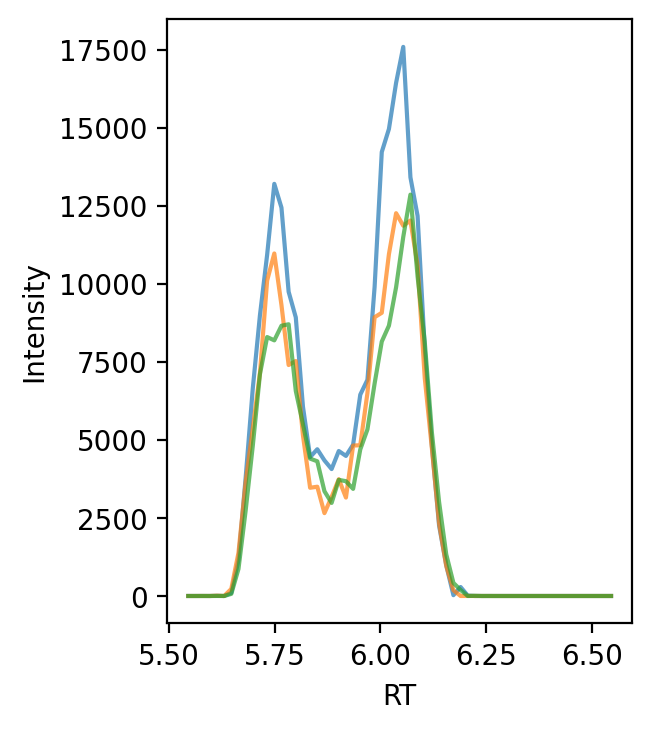

In [19]:
def plot_overlayedEIC(rawdatas,mz,rt_start,rt_end,resolution=60,smoothing=0,alpha=0.3):
    ts = np.linspace(rt_start,rt_end,resolution)
    for data in rawdatas:
        s = data.interpolate_data(mz,rt_start,rt_end,smoothing)
        ints  = [np.max([x,0]) for x in s(ts)]
        plt.plot(ts,ints,alpha=alpha)

file = datadir + files[0]
print(files)
inds = list(peakList.index.values)
rd.shuffle(inds)
plt.figure(figsize=(3,4))
for i in inds:
    if i in ms1_peaks_curated[file].index.values:
        plot_overlayedEIC(raw_data,ms1_peaks_curated[file].at[i,"mz"],ms1_peaks_curated[file].at[i,"rt"]-.5,ms1_peaks_curated[file].at[i,"rt"]+.5,resolution=resolution,alpha=0.7)
        plt.xlabel("RT")
        plt.ylabel("Intensity")
        break

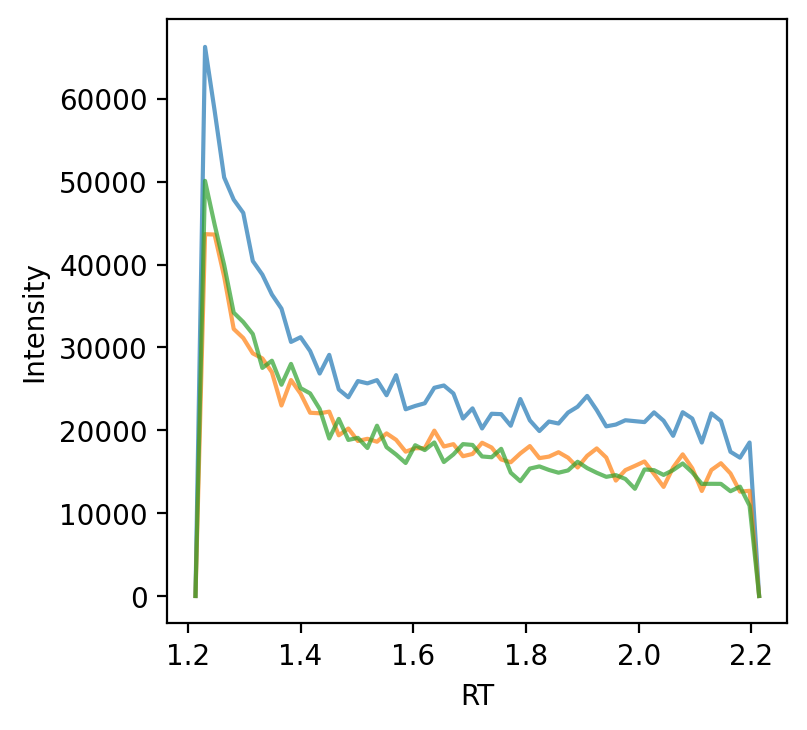

In [20]:
file = datadir + files[0]
inds = list(peakList.index.values)
rd.shuffle(inds)
plt.figure(figsize=(4,4))

for i in inds:
    if i not in ms1_peaks_curated[file].index.values:
        plot_overlayedEIC(raw_data,peakList.at[i,"mz"],peakList.at[i,"rt"]-.5,peakList.at[i,"rt"] + .5,resolution=resolution,alpha=0.7)
        plt.xlabel("RT")
        plt.ylabel("Intensity")
        break

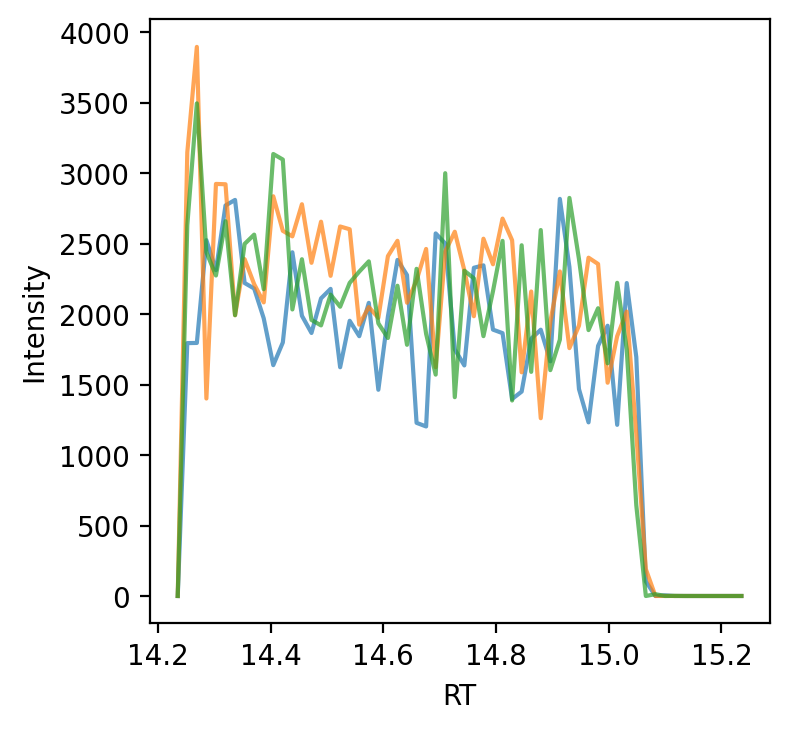

In [21]:
file = datadir + files[0]
inds = list(peakList.index.values)
rd.shuffle(inds)
plt.figure(figsize=(4,4))

for i in inds:
    if i not in ms1_peaks_curated[file].index.values:
        plot_overlayedEIC(raw_data,peakList.at[i,"mz"],peakList.at[i,"rt"]-.5,peakList.at[i,"rt"] + .5,resolution=resolution,alpha=0.7)
        plt.xlabel("RT")
        plt.ylabel("Intensity")
        break

In [22]:
true = []
pred = []
file = files[0]
for index,row in peakList_labeled.iterrows():
    if index in order:
        if index in ms1_peaks_curated[datadir + file].index.values:
            pred.append(1.0)
        else:
            pred.append(0.0)
        true.append(row["classification"])
print(len(true),confusion_matrix(true,pred))
met.accuracy_score(true,pred)

NameError: name 'order' is not defined

In [42]:
peak_scores

,mz,rt,../data/mzMLs/covid_plasma/B1_NIST1950_1_6540.mzML,../data/mzMLs/covid_plasma/B1_NIST1950_2_6540.mzML,../data/mzMLs/covid_plasma/B1_NIST1950_3_6540.mzML
1,52.995260,5.082550,0.001247,0.001247,0.000443
2,54.977009,5.083667,1.000000,1.000000,1.000000
3,55.019199,6.030133,0.999742,0.999990,0.999992
4,57.034543,5.399525,0.999988,0.999714,0.999988
5,57.034540,1.583142,0.999997,1.000000,0.999992
...,...,...,...,...,...
3928,1612.974731,6.589500,0.997083,0.000723,0.000841
3929,1612.974770,2.198033,0.000946,0.999999,0.001077
3930,1613.978781,15.015317,0.637789,1.000000,0.521011
3931,1613.978738,2.198033,0.000138,0.999999,0.000205


0.9289

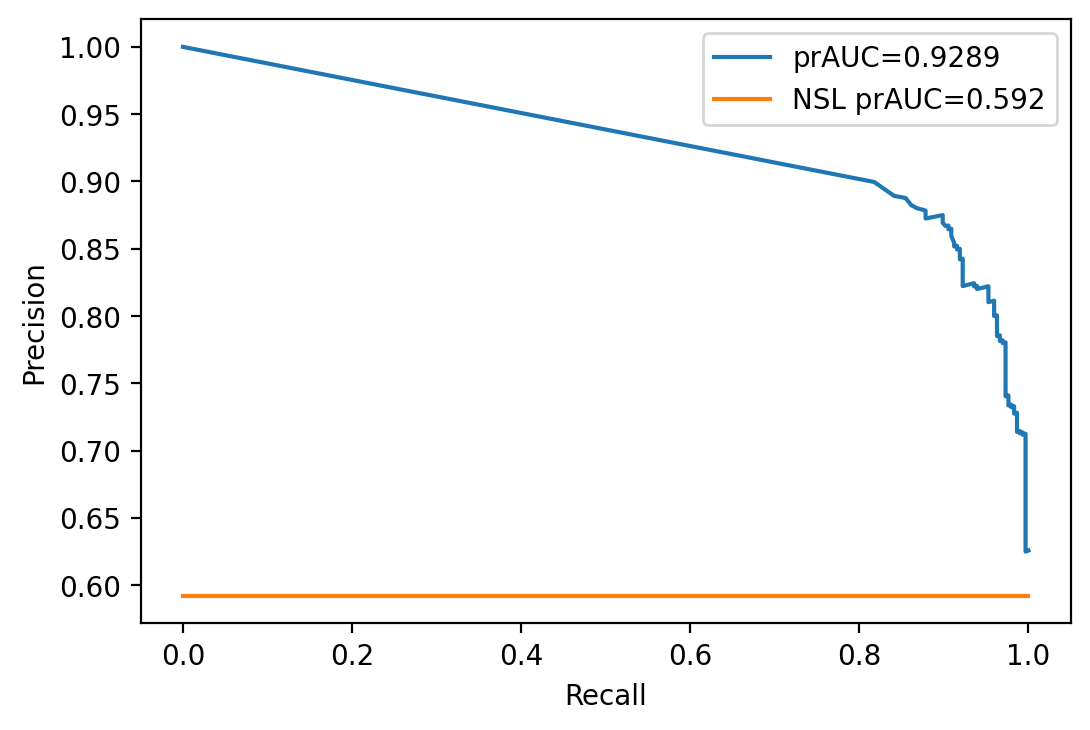

In [43]:
def makePRCPlot(pred,true,noSkill=True):

    prec, recall, threshs = met.precision_recall_curve(true, pred)

    auc = np.round(met.auc(recall, prec), 4)

    plt.plot(recall, prec, label="prAUC=" + str(auc))
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    if noSkill:
        numPositive = len([x for x in true if x > 0.5])
        numNegative = len(true) - numPositive
        plt.plot([0, 1.0],
                 [numPositive / float(numPositive + numNegative), numPositive / float(numPositive + numNegative)],
                 label="NSL prAUC=" + str(
                     np.round(numPositive / float(numPositive + numNegative), 4)))
    plt.legend()
    return auc

true = []
pred = []
file = files[0]
for index,row in peakList_labeled.iterrows():
    pred.append(peak_scores.at[index,datadir+file])
    true.append(row["classification"])

makePRCPlot(pred,true)